# Group Multiplication (S5) Analysis

In [273]:
%load_ext autoreload
%autoreload 2

import torch
from tasks.utils import fullbatch_fit
from tasks.datasets import sn5
from tasks.groups import SymmetricGroup
from tasks.subgroups import Subgroup, all_s5_subgroups_subwiki, all_s5_subgroups_dashiell
from sympy.combinatorics import Permutation, PermutationGroup
from tasks.models import Asymmetric, Concatenate, Additive, Config
from einops import *
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np

from tasks.utils import make_fourier_basis, to_fourier_basis

px_color = dict(color_continuous_midpoint=0, color_continuous_scale="RdBu")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train / Load Model

In [ ]:
torch.set_grad_enabled(True)

# model = Asymmetric(Config(n_classes=120)).to('mps')
model = Concatenate(Config(n_classes=120)).to('mps')
# model = Additive(Config(n_classes=120)).to('mps')

# This is what happens for both the asymmetric and the concatenate model:
# ~400 epochs: the training accuracy shoots up to 100%
# ~5,000 epochs: the validation accuracy shoots up to 99%
# ~10,000 epochs: the validation accuracy converges to 100%
# ~30,000 epochs: validation loss decreases substantially

# The additive model takes about 10k epochs to reach 100%

train, val = sn5(device='mps').split()
fullbatch_fit(model, train, val, epochs=100_000, project="modulo", wd=1.0)

In [171]:
# file_path = 'data/group-s5-concat-long.pt'
# data = {'config': model.config, 'state_dict': model.state_dict()}
# torch.save(data, file_path)

In [274]:
file_path = 'data/group-s5-concat-long2.pt'
# file_path = 'data/group-s5-concat-long-d128.pt'

# file_path = 'data/group-s5-add-long-d256.pt'
# file_path = 'data/group-s5-add-long-d128.pt'

data = torch.load(file_path)
config = data['config']

model = Concatenate(config).to('mps')
# model = Additive(config).to('mps')

model.load_state_dict(data['state_dict'])
torch.set_grad_enabled(False)
config

Config {
  "d_model": 256,
  "n_classes": 120,
  "transformers_version": "4.37.2"
}

# Higher Order SVD

1. Get the third-order bilinear tensor (two input and one output dim)
2. Flatten the two input dims to get a matrix
3. Compute the SVD

In [275]:
w_u = model.unembed.weight
w_l, w_r = model.bilinear.w_l, model.bilinear.w_r

w_el = model.left.weight
w_er = model.right.weight
w_e = torch.block_diag(w_el, w_er)

b = einsum(w_u, w_l, w_r, "cl out, out in1, out in2 -> cl in1 in2")
b = 0.5 * (b + b.mT)

# b = einsum(b, w_e, w_e, "cl in1 in2, elem1 in1, elem2 in2 -> cl elem1 elem2")

u, s, v = torch.svd(b.flatten(start_dim=1))
px.line(s.cpu())

In [276]:
px.imshow(w_u.cpu(), **px_color)

# Find relevant cosets

In [267]:
# get group elements

s5 = SymmetricGroup(5)
G = s5.G
signs = s5.compute_signatures().cpu()
perms = [s5.idx_to_perm(idx) for idx in torch.arange(s5.order)]

Computing multiplication table...
... loading from file


In [268]:
def coset_variances_over_all_subgroups(vector, subgroups_dict = all_s5_subgroups_subwiki, G = G):
# vector: vector over group elements to compute variances over
# subgroups_dict: dict with generators for subgroup
# search over subgroups
# for each subgroup compute variance over cosets divided by overall variance

    coset_scores = []
    for key in subgroups_dict.keys():
        H = PermutationGroup(subgroups_dict[key]['generators'])
        subgroup = Subgroup(G,H)

        for conj_idx, conj_H in enumerate(subgroup.conjugate_H):
            subgroup_name = f"{key}:{conj_idx}"

            assert conj_H.order() == subgroups_dict[key]['order']
            assert conj_H.is_subgroup(G)

            for coset_type in ['left', 'right']:
                coset_idxs = subgroup.coset_indices(conj_idx, coset_type)
                
                coset_variances = [vector[idxs].var() for idxs in coset_idxs]
                score = sum(coset_variances) / vector.var()

                coset_score = {'subgroup': key, 'conjugate': conj_idx, 'coset': coset_type, 'score': score.item(), 'order':conj_H.order()}
                coset_scores.append(coset_score)
    return pd.DataFrame(coset_scores)

### Singular vectors

In [281]:
s_idx = 2
vector = u[:,s_idx]
df = coset_variances_over_all_subgroups(vector)
df = df.sort_values('score')
df[:10]

subgroup  conjugate  coset     score  order
163                       C6          5  right  0.019027      6
95                        C3          2  right  0.034224      3
19   C2_single_transposition          9  right  0.086944      2
106                       C3          8   left  1.456611      3
288                       A4          2   left  1.539611     12
295                       A5          0  right  2.016948     60
294                       A5          0   left  2.016948     60
154                       C6          1   left  2.665693      6
291                       A4          3  right  3.913051     12
293                       A4          4  right  4.210097     12

In [282]:
eig_idx = -1

d = int(np.sqrt(v.shape[0]))
q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1 = d, in2 = d)[s_idx].cpu()
eigvals, eigvecs = torch.linalg.eigh(q)

w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
l, r = rearrange(eigvecs[:, eig_idx], "(s emb) -> s emb", s=2)
left = einsum(l, w_el, "emb, inp emb -> inp").cpu()
right = einsum(r, w_er, "emb, inp emb -> inp").cpu()

left_df = coset_variances_over_all_subgroups(left)
left_df = left_df.sort_values('score')
print(left_df[:10])

right_df = coset_variances_over_all_subgroups(right)
right_df = right_df.sort_values('score')
print(right_df[:10])

                    subgroup  conjugate  coset     score  order
163                       C6          5  right  0.013981      6
95                        C3          2  right  0.018423      3
19   C2_single_transposition          9  right  0.065106      2
294                       A5          0   left  2.016942     60
295                       A5          0  right  2.016942     60
46   C2_double_transposition         13   left  2.298721      2
291                       A4          3  right  3.887719     12
293                       A4          4  right  4.231748     12
172               S3_twisted          0   left  4.259278      6
288                       A4          2   left  4.979764     12
                     subgroup  conjugate  coset     score  order
106                        C3          8   left  0.143365      3
288                        A4          2   left  0.214346     12
92                         C3          1   left  0.746710      3
58   K4_double_transpositions       

### Unembedding Matrix

In [283]:
px.imshow(w_u.cpu(), **px_color)

In [284]:
count = 0

rows = []
for i in range(w_u.shape[1]):
    vector = w_u[:,i]
    if vector.std() < 1e-5:
        continue

    print(f'Column {count}, idx {i}')
    df = coset_variances_over_all_subgroups(vector)
    df = df.sort_values('score')
    print(df[:5])
    
    row = df.iloc[0].copy()
    row['col_idx'] = i
    rows.append(row)
    count+=1

df = pd.concat(rows, axis=1).T.reset_index()


Column 0, idx 4
    subgroup  conjugate  coset     score  order
294       A5          0   left  0.000508     60
295       A5          0  right  0.000508     60
285       A4          0  right  0.002204     12
292       A4          4   left  0.002310     12
284       A4          0   left  0.002374     12
Column 1, idx 13
                     subgroup  conjugate coset     score  order
288                        A4          2  left  0.002677     12
58   K4_double_transpositions          4  left  0.007778      4
106                        C3          8  left  0.009501      3
98                         C3          4  left  0.010612      3
102                        C3          6  left  0.011117      3
Column 2, idx 19
                     subgroup  conjugate  coset     score  order
290                        A4          3   left  0.002909     12
52   K4_double_transpositions          1   left  0.008165      4
127                        C4          8  right  0.009260      4
100               

In [285]:
df.sort_values(['subgroup', 'conjugate'])

index subgroup conjugate  coset     score order col_idx
4     284       A4         0   left  0.002531    12      34
6     285       A4         0  right  0.014059    12      36
14    285       A4         0  right  0.014018    12     107
15    285       A4         0  right  0.016765    12     108
21    285       A4         0  right  0.015994    12     163
24    285       A4         0  right  0.012374    12     196
26    284       A4         0   left  0.002857    12     231
27    285       A4         0  right  0.009535    12     234
19    286       A4         1   left  0.003104    12     134
23    286       A4         1   left  0.002906    12     191
1     288       A4         2   left  0.002677    12      13
12    288       A4         2   left  0.002562    12      76
2     290       A4         3   left  0.002909    12      19
3     290       A4         3   left   0.00312    12      32
8     292       A4         4   left  0.003078    12      44
10    292       A4         4   left  0.002921    12      61
0     294       A5         0   left  0.000508    60       4
5     295       A5         0  right  0.000657    60      35
7     106       C3         8   left  0.026801     3      41
17    106       C3         8   left  0.033077     3     119
18    106       C3         8   left  0.028783     3     133
25    106       C3         8   left  0.022497     3     228
9     121       C4         5  right  0.093748     4      52
11    121       C4         5  right  0.094688     4      73
13    121       C4         5  right  0.098578     4      80
16    121       C4         5  right   0.10932     4     118
20    121       C4         5  right  0.113079     4     157
22    121       C4         5  right  0.098583     4     164

# Singular Value 0: Alternating Group 

In [185]:
from tasks.groups import SymmetricGroup

s5 = SymmetricGroup(5)
signs = s5.compute_signatures().cpu()
perms = [s5.idx_to_perm(idx) for idx in torch.arange(s5.order)]

s_idx = 1
outputs = u[:,s_idx].cpu()
px.bar(x=range(0, len(s)), y=outputs.sort().values, labels={'x':'Output Idx', 'y':'Output Singular Vector'}, title=f'Singular Value {s_idx}', **px_color)

Computing multiplication table...
... loading from file


In [186]:
d = int(np.sqrt(v.shape[0]))
q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1 = d, in2 = d)[s_idx].cpu()
# px.imshow(v.cpu(), **color)
vals, vecs = torch.linalg.eigh(q)
px.line(vals.cpu(), title=f'Eigenvalues for Singular Value {s_idx}')

In [123]:
w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)
# w_e = torch.cat([w_el, w_er], dim=0)

interaction_matrix = einsum(q, w_e, w_e, 'in1 in2, left in1, right in2 -> left right')

idxs = torch.cat([
    torch.arange(len(signs))[signs==1],
    torch.arange(len(signs))[signs==-1]
])
cat_idxs = torch.cat([idxs, len(idxs) + idxs])

px.imshow(interaction_matrix[cat_idxs,:][:,cat_idxs], **px_color)


In [199]:
eig_idx = -1

w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()

l, r = rearrange(vecs[:, eig_idx], "(s emb) -> s emb", s=2)
left = einsum(l, w_el, "emb, inp emb -> inp").cpu()
right = einsum(r, w_er, "emb, inp emb -> inp").cpu()

sort_idxs = torch.argsort(left)
xlabels = [str(perms[idx]) for idx in sort_idxs]
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Bar(x=xlabels, y=left[sort_idxs]), 
    row=1, col=1
)

sort_idxs = torch.argsort(right)
xlabels = [str(perms[idx]) for idx in sort_idxs]
fig.add_trace(
    go.Bar(x=xlabels, y=right[sort_idxs]), 
    row=1, col=2
)
fig.show()

# plt.figure(figsize=(8,3.5), dpi=150)
# plt.subplot(1,2,1)
# plt.bar(torch.arange(len(left)), left)

# plt.subplot(1,2,2)
# plt.bar(torch.arange(len(right)), right)

# plt.figure(figsize=(8,3.5), dpi=150)
# plt.subplot(1,2,1)
# plt.plot(signs, left, '.')

# plt.subplot(1,2,2)
# plt.plot(signs, right, '.')
# px.bar((einsum(l, w_el, "emb, inp emb -> inp")).cpu(), labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Left Input').show()
# px.bar((einsum(r, w_er, "emb, inp emb -> inp")).cpu(), labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Right Input').show()

# Cosets

In [126]:
s_idx = 0

d = int(np.sqrt(v.shape[0]))
q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1 = d, in2 = d)[s_idx].cpu()

w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)
# w_e = torch.cat([w_el, w_er], dim=0)

interaction_matrix = einsum(q, w_e, w_e, 'in1 in2, left in1, right in2 -> left right')

H_key = 'A5'
gen_idx = 0
generators = all_s5_subgroups_subwiki[H_key]['generators']
H = PermutationGroup(generators)
subgroup = Subgroup(G,H)
coset1_idxs = subgroup.coset_indices(gen_idx, 'right')

H_key = 'C2_double_transposition'
gen_idx = 4
generators = all_s5_subgroups_subwiki[H_key]['generators']
H = PermutationGroup(generators)
subgroup = Subgroup(G,H)
coset2_idxs = subgroup.coset_indices(gen_idx, 'left')

left_idxs = torch.cat([torch.tensor(idxs) for idxs in coset1_idxs])
right_idxs = len(left_idxs) + torch.cat([torch.tensor(idxs) for idxs in coset2_idxs])
# cat_idxs = torch.cat([left_idxs, len(left_idxs) + right_idxs])

px.imshow(interaction_matrix[right_idxs,:][:,left_idxs], **px_color)

In [752]:
s5 = SymmetricGroup(5)
G = s5.G
signs = s5.compute_signatures().cpu()
perms = [s5.idx_to_perm(idx) for idx in torch.arange(s5.order)]
H = get_s5_subgroup('C6', 4)
C = Cosets(G,H)
print(C.H.order())

Computing multiplication table...
... loading from file
6


In [753]:
for s_idx in [1,2,3,4]:
    outputs = u[:,s_idx].cpu()

    coset_idxs = C.coset_indices('right')

    out_df = pd.DataFrame({
                        'p_idx': list(range(s5.order)),
                        'permutation': [str(perm) for perm in perms], 
                        'signature': signs, 'output': outputs})

    df_list = []
    for i, idxs in enumerate(coset_idxs):
        df = out_df.iloc[idxs].copy()
        df['coset'] = i
        df_list.append(df)
    df = pd.concat(df_list)

    fig = px.bar(df, x='permutation', y='output', color ='coset',
        labels={'permutation':'Permutation', 'output':'Output Singular Vector'}, 
        title=f'Singular Value {s_idx}',
        )
    # fig.update_layout(
    #     xaxis = dict(
    #         tickvals = list(range(len(df['p_idx']))),
    #         ticktext = df['p_idx']
    #     )
    # )
    fig.show()

# sort_idxs = outputs.argsort()
# xlabels = [str(perms[idx]) for idx in sort_idxs]
# px.bar(x=xlabels, y=outputs[sort_idxs], labels={'x':'Output Idx', 'y':'Output Singular Vector'}, title=f'Singular Value {s_idx}', **px_color)

In [104]:
# for s_idx in [1,2,3,4]:
s_idx = 3

q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1 = 512, in2 = 512)[s_idx].cpu()

w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)
# w_e = torch.cat([w_el, w_er], dim=0)

interaction_matrix = einsum(q, w_e, w_e, 'in1 in2, left in1, right in2 -> left right')

H_key = 'C6'
gen_idx = 5
generators = all_s5_subgroups_subwiki[H_key]['generators']
H = PermutationGroup(generators)
subgroup = Subgroup(G,H)
coset1_idxs = subgroup.coset_indices(gen_idx, 'right')

H_key = 'C3'
gen_idx = 2
generators = all_s5_subgroups_subwiki[H_key]['generators']
H = PermutationGroup(generators)
subgroup = Subgroup(G,H)
coset2_idxs = subgroup.coset_indices(gen_idx, 'left')

left_idxs = torch.cat([torch.tensor(idxs) for idxs in coset1_idxs])
right_idxs = len(left_idxs) + torch.cat([torch.tensor(idxs) for idxs in coset2_idxs])
# cat_idxs = torch.cat([left_idxs, len(left_idxs) + right_idxs])

px.imshow(interaction_matrix[right_idxs,:][:,left_idxs], **px_color)

In [724]:
s_idx = 2

q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1 = 512, in2 = 512)[s_idx].cpu()
eigvals, eigvecs = torch.linalg.eigh(q)
px.line(x=range(0, len(eigvals)), y=eigvals, labels={'x':'Index', 'y':'Eigenvalues'}, title=f'Eigenvalues for Singular Vector Comp. {s_idx}')

In [784]:
for s_idx in [1]:

    q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1 = 512, in2 = 512)[s_idx].cpu()
    eigvals, eigvecs = torch.linalg.eigh(q)
    # px.line(x=range(0, len(eigvals)), y=eigvals, labels={'x':'Index', 'y':'Eigenvalues'}, title=f'Eigenvalues for Singular Vector Comp. {s_idx}')

    eig_idx = -1

    w_el = model.left.weight.cpu()
    w_er = model.right.weight.cpu()
    l, r = rearrange(eigvecs[:, eig_idx], "(s emb) -> s emb", s=2)
    left = einsum(l, w_el, "emb, inp emb -> inp").cpu()
    right = einsum(r, w_er, "emb, inp emb -> inp").cpu()

    H = get_s5_subgroup('C6', 4)
    C = Cosets(G, H)
    coset_idxs = C.coset_indices('right')
    df = pd.concat([pd.DataFrame({'x': [str(s5.idx_to_perm(idx)) for idx in idxs],'y': left[idxs], 'color':i}) for i, idxs in enumerate(coset_idxs)])
    px.bar(df, x='x', y='y', color='color').show()

    for i in range(10):
        H = get_s5_subgroup('C3', i)
        C2 = Cosets(G, H)
        coset_idxs = C2.coset_indices('left')
        df = pd.concat([pd.DataFrame({'x': [str(s5.idx_to_perm(idx)) for idx in idxs],'y': right[idxs], 'color':i}) for i, idxs in enumerate(coset_idxs)])
        px.bar(df, x='x', y='y', color='color', title=f'Subgroup C3 generator {i}').show()

# Given output vector

In [127]:
w_u = model.unembed.weight
w_l, w_r = model.bilinear.w_l, model.bilinear.w_r

w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)

b = einsum(w_u, w_l, w_r, "cl out, out in1, out in2 -> cl in1 in2")
b = 0.5 * (b + b.mT)

In [ ]:
H_key = 'A5'
gen_idx = 0
generators = all_s5_subgroups_subwiki[H_key]['generators']
H = PermutationGroup(generators)
subgroup = Subgroup(G,H)
coset_idxs = subgroup.coset_indices(gen_idx, 'right')

output_vec = torch.zeros()

In [ ]:
s_idx = 0

d = int(np.sqrt(v.shape[0]))
q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1 = d, in2 = d)[s_idx].cpu()

w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)
# w_e = torch.cat([w_el, w_er], dim=0)

interaction_matrix = einsum(q, w_e, w_e, 'in1 in2, left in1, right in2 -> left right')

H_key = 'A5'
gen_idx = 0
generators = all_s5_subgroups_subwiki[H_key]['generators']
H = PermutationGroup(generators)
subgroup = Subgroup(G,H)
coset1_idxs = subgroup.coset_indices(gen_idx, 'right')

H_key = 'C2_double_transposition'
gen_idx = 4
generators = all_s5_subgroups_subwiki[H_key]['generators']
H = PermutationGroup(generators)
subgroup = Subgroup(G,H)
coset2_idxs = subgroup.coset_indices(gen_idx, 'left')

left_idxs = torch.cat([torch.tensor(idxs) for idxs in coset1_idxs])
right_idxs = len(left_idxs) + torch.cat([torch.tensor(idxs) for idxs in coset2_idxs])
# cat_idxs = torch.cat([left_idxs, len(left_idxs) + right_idxs])

px.imshow(interaction_matrix[right_idxs,:][:,left_idxs], **px_color)

# Eigenvalues

In [450]:
from tasks.groups import SymmetricGroup

s5 = SymmetricGroup(5)
signs = s5.compute_signatures().cpu()
perms = [s5.idx_to_perm(idx) for idx in torch.arange(s5.order)]
C = Cosets(G, 'F20 in S5')

w_u = model.unembed.weight
w_l, w_r = model.bilinear.w_l, model.bilinear.w_r

b = einsum(w_u, w_l, w_r, "cl out, out in1, out in2 -> cl in1 in2")
b = 0.5 * (b + b.mT)
b = b.cpu()

Computing multiplication table...
... loading from file


In [451]:
coset = 0
coset_indices = C.coset_indices('left')
output = 0 * torch.ones(120)
output[coset_indices[coset]] = 1

q = einsum(b, output, "cls in1 in2, cls -> in1 in2").cpu()
eigvals, eigvecs = torch.linalg.eigh(q)
px.line(x=range(0, len(eigvals)), y=eigvals, labels={'x':'Output Idx', 'y':'Output Singular Vector'}, title=f'Singular Value {s_idx}')

In [455]:
w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)
# w_e = torch.cat([w_el, w_er], dim=0)

interaction_matrix = einsum(q, w_e, w_e, 'in1 in2, left in1, right in2 -> left right')

# left_idxs = torch.cat([torch.tensor(c_idxs) for c_idxs in C.coset_indices('left')])
# right_idxs = torch.cat([torch.tensor(c_idxs) for c_idxs in C.coset_indices('right')])
# cat_idxs = torch.cat([right_idxs, len(right_idxs) + left_idxs])

idxs = torch.cat([
    torch.arange(len(signs))[signs==1],
    torch.arange(len(signs))[signs==-1]
])
cat_idxs = torch.cat([idxs, len(idxs) + idxs])

px.imshow(interaction_matrix[cat_idxs, :][:,cat_idxs], **px_color)
# px.imshow(interaction_matrix, **px_color)

In [419]:
eigvals, eigvecs = torch.linalg.eigh(q)

eig_idx = 2
vec = w_e @ eigvecs[:, eig_idx]

left_idxs = torch.cat([torch.tensor(c_idxs) for c_idxs in C.coset_indices('left')])
right_idxs = torch.cat([torch.tensor(c_idxs) for c_idxs in C.coset_indices('right')])
cat_idxs = torch.cat([left_idxs, len(right_idxs) + right_idxs])

# sign_idxs = torch.cat([
#     torch.arange(len(signs))[signs==1],
#     torch.arange(len(signs))[signs==-1]
# ])
# cat_idxs = torch.cat([sign_idxs, len(sign_idxs) + sign_idxs])

px.bar(vec[cat_idxs], labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Input Singular Vector')

In [ ]:
w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)
# w_e = torch.cat([w_el, w_er], dim=0)

vec = 
interaction_matrix = einsum(q, w_e, w_e, 'in1 in2, left in1, right in2 -> left right')

# left_idxs = torch.cat([torch.tensor(c_idxs) for c_idxs in C.coset_indices('left')])
# right_idxs = torch.cat([torch.tensor(c_idxs) for c_idxs in C.coset_indices('right')])
# cat_idxs = torch.cat([right_idxs, len(right_idxs) + left_idxs])

# idxs = torch.cat([
#     torch.arange(len(signs))[signs==1],
#     torch.arange(len(signs))[signs==-1]
# ])
# cat_idxs = torch.cat([idxs, len(idxs) + idxs])

px.imshow(interaction_matrix[cat_idxs, :][:,cat_idxs], **px_color)
# px.imshow(interaction_matrix, **px_color)

In [351]:
out_idx = 0
eigvals, eigvecs = torch.linalg.eigh(b[out_idx].cpu())

px.line(x=range(0, len(eigvals)), y=eigvals, labels={'x':'Output Idx', 'y':'Output Singular Vector'}, title=f'Singular Value {s_idx}')

In [293]:
w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()
w_e = torch.block_diag(w_el, w_er)

In [294]:
eig_idx = -1

vec = w_e @ eigvecs[:, eig_idx]

px.bar(vec.sort().values, labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Input Singular Vector')


# Singular Value 1

In [391]:
from tasks.groups import SymmetricGroup

s5 = SymmetricGroup(5)
signs = s5.compute_signatures().cpu()
G = s5.G
perms = [s5.idx_to_perm(idx) for idx in torch.arange(s5.order)]
C = Cosets(G, 'S4 in S5')

Computing multiplication table...
... loading from file


In [385]:
s_idx = 
outputs = u[:,s_idx].cpu()

sort_idxs = outputs.argsort()
xlabels = [str(perms[idx]) for idx in sort_idxs]
px.bar(x=xlabels, y=outputs[sort_idxs], labels={'x':'Output Idx', 'y':'Output Singular Vector'}, title=f'Singular Value {s_idx}', **px_color)

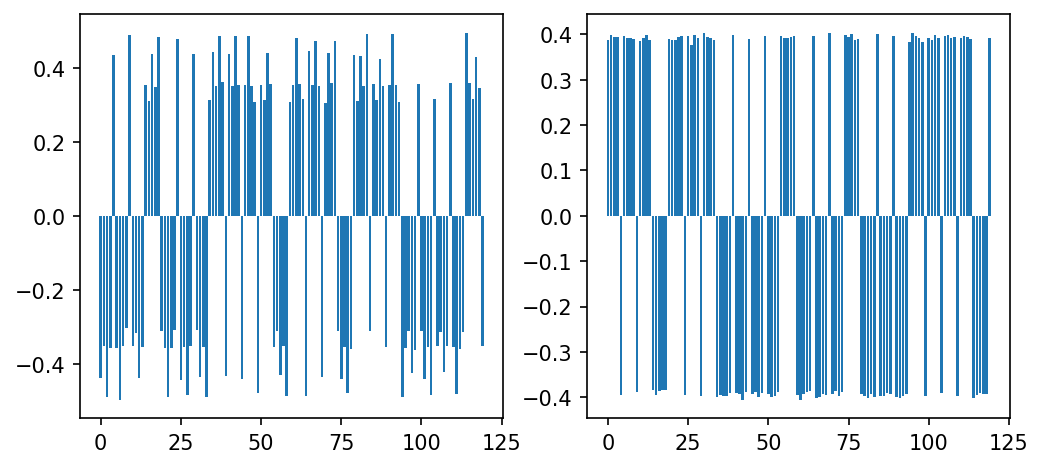

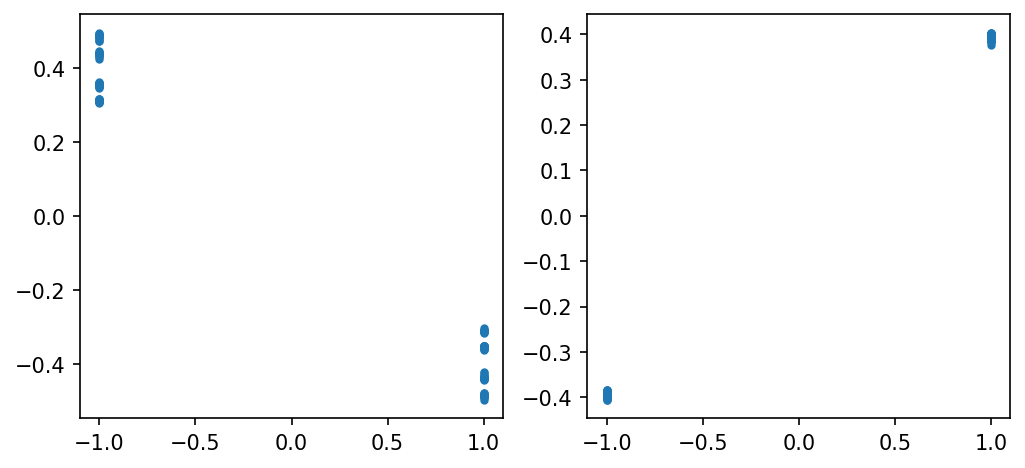

In [33]:
eig_idx = -1

w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()

l, r = rearrange(vecs[:, eig_idx], "(s emb) -> s emb", s=2)
left = einsum(l, w_el, "emb, inp emb -> inp").cpu()
right = einsum(r, w_er, "emb, inp emb -> inp").cpu()

plt.figure(figsize=(8,3.5), dpi=150)
plt.subplot(1,2,1)
plt.bar(torch.arange(len(left)), left)

plt.subplot(1,2,2)
plt.bar(torch.arange(len(right)), right)

plt.figure(figsize=(8,3.5), dpi=150)
plt.subplot(1,2,1)
plt.plot(signs, left, '.')

plt.subplot(1,2,2)
plt.plot(signs, right, '.')
# px.bar((einsum(l, w_el, "emb, inp emb -> inp")).cpu(), labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Left Input').show()
# px.bar((einsum(r, w_er, "emb, inp emb -> inp")).cpu(), labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Right Input').show()

Text(0, 0.5, 'Singular Vector Output')

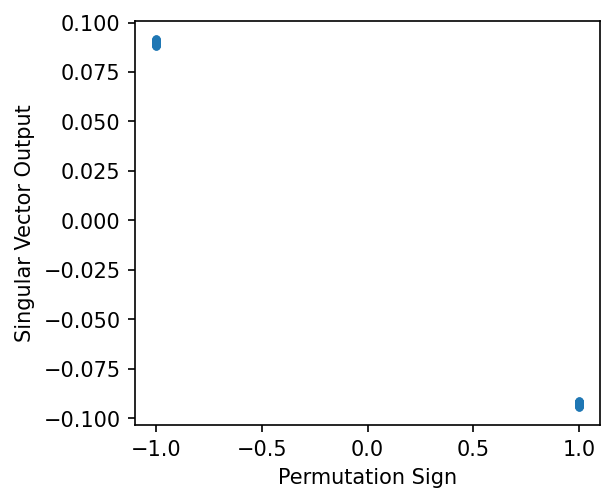

In [183]:
# plt.hist(outputs[signs==1], bins=5, alpha=0.5, density=True, label='Sign=1')
# plt.hist(outputs[signs==-1], bins=5, alpha=0.5, density=True, label='Sign=-1')

plt.figure(figsize=(4,3.5), dpi=150)
plt.plot(signs, outputs, '.')
plt.xlabel('Permutation Sign')
plt.ylabel('Singular Vector Output')

In [155]:
mult_table = model.group.compute_multiplication_table()
model.group.compute_element_orders()
model.group.orders

Computing multiplication table...
... loading from file


[3]

In [158]:
from sympy.combinatorics.named_groups import SymmetricGroup

s5 = SymmetricGroup(5)

In [170]:
s5

120

In [82]:
dir(s5)

['__annotations__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__sympy__',
 '__weakref__',
 '_args',
 '_assumptions',
 '_base',
 '_basic_orbits',
 '_block_verify',
 '_center',
 '_compare_pretty',
 '_constructor_postprocessor_mapping',
 '_coset_representative',
 '_degree',
 '_distinct_primes_lemma',
 '_do_eq_sympify',
 '_elements',
 '_eval_derivative_n_times',
 '_eval_is_alt_sym_monte_carlo',
 '_eval_is_alt_sym_naive',
 '_eval_rewrite',
 '_eval_subs',
 '_exec_constructor_postprocessors',
 '_explicit_class_assumptions',
 '_fp_presentation',
 '_generators',
 '

In [66]:
(u[:,0] > 0).sum()

tensor(60, device='mps:0')

In [106]:
v.shape

torch.Size([65536, 120])

In [135]:
s_idx = 0
q = rearrange(v, "(in1 in2) mid -> mid in1 in2", in1=512, in2=512)[idx].cpu()
# px.imshow(v.cpu(), **color)
vals, vecs = torch.linalg.eigh(q)
px.line(vals.cpu(), title=f'Eigenvalues for Singular Value {s_idx}')

In [136]:
w_el = model.left.weight.cpu()
w_er = model.right.weight.cpu()

l, r = rearrange(vecs[:, -1], "(s emb) -> s emb", s=2)
# vec = vecs[:,0]
px.bar((einsum(l, w_el, "emb, inp emb -> inp")).cpu(), labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Left Input').show()
px.bar((einsum(r, w_er, "emb, inp emb -> inp")).cpu(), labels={'x':'Input Idx', 'y':'Input Singular Vector'}, title='Right Input').show()

In [39]:
mult_table = torch.load('utils/cache/S5/S5_mult_table.pt', map_location='cpu')
px.imshow(mult_table, **color)

In [64]:
s_idx = 5
px.bar(x=range(0, len(s)), y=u[:,s_idx].cpu(), labels={'x':'Output Idx', 'y':'Output Singular Vector'}, title=f'Singular Value {s_idx}', **color)

In [ ]:
s_idx = 1
px.bar(x=range(0, len(s)), y=u[:,s_idx].cpu(), labels={'x':'Output Idx', 'y':'Output Singular Vector'}, title=f'Singular Value {s_idx}', **color)

In [24]:
def make_fourier_basis(p: int):
    fourier_basis = torch.ones(p, p)
    
    for i in range(1, p // 2 + 1):
        fourier_basis[2*i-1] = torch.cos(2*torch.pi*torch.arange(p)*i/p)
        fourier_basis[2*i] = torch.sin(2*torch.pi*torch.arange(p)*i/p)

    fourier_basis /= fourier_basis.norm(dim=1, keepdim=True)
    return fourier_basis

In [65]:
fft = torch.fft.rfft(u[:,5].cpu())

px.bar(torch.real(fft)).show()
px.bar(torch.imag(fft)).show()

In [103]:
w_r = model.right.weight.T
w_l = model.left.weight.T
w_u = model.unembed.weight

b = einsum(w_u, w_l, w_r, "cls mid, mid in1, mid in2 -> cls in1 in2")
px.imshow(b[0].cpu(), **px_color).show()

# We can't use eigh since the matrix is not symmetric. The imaginary eigenvalues seem interesting.
# Since the matrix is real, the eigenvalues come in conjugate pairs. but some of them are real and show structure.
vals, vecs = torch.linalg.eig(b[0].cpu())
# px.scatter(x=vals.real.cpu(), y=vals.imag.cpu(), color=vals.abs().cpu()).show()
px.scatter(x=vals.real.cpu(), y=vals.imag.cpu(), color=list(range(120))).show()

# Not all too sure how to visualize the eigenvectors
px.scatter(x=vecs[:, 0].real.cpu(), y=vecs[:, 0].imag.cpu(), color=vecs[:, 0].abs().cpu()).show()

In [101]:
b[0]

tensor([[ 0.0198,  0.0089,  0.0404,  ...,  0.0313, -0.0317, -0.0183],
        [ 0.0108,  0.0302,  0.0421,  ..., -0.0182, -0.0556, -0.0449],
        [ 0.0146,  0.0098, -0.0049,  ..., -0.0433, -0.0042,  0.0046],
        ...,
        [-0.0845,  0.0509,  0.0038,  ..., -0.0043,  0.0276,  0.0069],
        [-0.0186, -0.0546, -0.0073,  ...,  0.0290,  0.0275, -0.0248],
        [ 0.0232, -0.0069, -0.0582,  ...,  0.0312,  0.0604,  0.0321]],
       device='mps:0')